In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from scipy.stats import norm, t, skew, kurtosis
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import LedoitWolf
import warnings

In [37]:
warnings.filterwarnings('ignore')

years = 25
risk_free_rate = 0.02
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)
tickers = ['VTI', 'VXUS', 'BND', 'VTEB', 'VNQ']
portfolio_value = 500000
days = 5

adj_close_df = pd.DataFrame()
for ticker in tickers:
    try:
        data = yf.download(ticker, start = startDate, end = endDate)
        adj_close_df[ticker] = data['Close']
    except Excpetion as e:
        print(f"Error Downloading {ticker}: {e}")

log_returns = np.log(adj_close_df/adj_close_df.shift(1)).dropna()
weights = np.array([1/len(tickers)]*len(tickers))
historical_returns = (log_returns * weights).sum(axis=1)
historical_x_days_returns = historical_returns.rolling(window = days).sum()

cov_matrix = log_returns.cov() * 252 
lw = LedoitWolf()
robust_cov = pd.DataFrame(lw.fit(log_returns).covariance_ * 252, 
                         index=log_returns.columns, 
                         columns=log_returns.columns)

portfolio_std_dev = np.sqrt(weights.T @ cov_matrix @ weights)
portfolio_std_dev_robust = np.sqrt(weights.T @ robust_cov @ weights)
returns_data = log_returns

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
'''
The Following are were made with the assistance of AI for learning purposes.
1)Portfolio Optimization
2)Stress Testing
3)Any Plotting
'''

In [43]:
def calculate_portfolio_performance(weights_array, returns_df, risk_free_rate=0.02):
    mean_returns = returns_df.mean().values
    portfolio_return = np.sum(mean_returns * weights_array) * 252

    cov_matrix = returns_df.cov().values
    portfolio_variance = np.dot(weights_array.T, np.dot(cov_matrix, weights_array))
    portfolio_volatility = np.sqrt(portfolio_variance)
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def print_results(weights, ret, vol, sharpe, method):
    print(f"\n{method} Portfolio")
    print(f"Weights: {[f'{w:.3f}' for w in weights]}")
    print(f"Risk: {vol*100:.2f}%, Return: {ret*100:.2f}%, Sharpe: {sharpe:.3f}")

def find_minimum_variance_portfolio(returns_df):
    n_assets = len(returns_df.columns)
    def portfolio_variance(weights):
        cov_matrix = returns_df.cov().values
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
    bounds = tuple((0,1) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    results = minimize(
        fun=portfolio_variance,
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints  
    )
    if results.success:
        optimal_weights = results.x
        ret, vol, sharpe = calculate_portfolio_performance(optimal_weights, returns_df)
        print(f"Found optimal weights: {[f'{w:.3f}' for w in optimal_weights]}")
        print(f"Risk: {vol*100:.2f}%, Return: {ret*100:.2f}%, Sharpe: {sharpe:.3f}")
        
        return {
            'weights': optimal_weights,
            'return': ret,
            'volatility': vol,
            'sharpe_ratio': sharpe,
            'method': 'Minimum Variance'
        }
    else:
        print("Optimization failed")
        return None
def find_maximum_sharpe_portfolio(returns_df):
    n_assets=len(returns_df.columns)
    def negative_sharpe(weights):
        ret, vol, sharpe = calculate_portfolio_performance(weights, returns_df)
        return -sharpe
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1)for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    results = minimize(
        fun=negative_sharpe,
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if results.success:
        optimal_weights = results.x
        ret, vol, sharpe = calculate_portfolio_performance(optimal_weights, returns_df)
        
        print(f"Found optimal weights: {[f'{w:.3f}' for w in optimal_weights]}")
        print(f"Risk: {vol*100:.2f}%, Return: {ret*100:.2f}%, Sharpe: {sharpe:.3f}")
        
        return {
            'weights': optimal_weights,
            'return': ret,
            'volatility': vol,
            'sharpe_ratio': sharpe,
            'method': 'Maximum Sharpe'
        }
    else:
        print("Optimization failed")
        return None
def find_risk_parity_portfolio(returns_df):
    n_assets = len(returns_df.columns)
    def risk_parity_objective(weights):
        cov_matrix = returns_df.cov().values
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_volatility = np.sqrt(portfolio_variance)
        marginal_contributions = np.dot(cov_matrix,weights) / portfolio_volatility
        risk_contributions = weights * marginal_contributions
        target_risk_contribution = portfolio_volatility / n_assets
        deviations = risk_contributions - target_risk_contribution
        return np.sum(deviations**2)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.001, 0.999) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    result = minimize(
        fun=risk_parity_objective,
        x0=initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    if result.success:
        optimal_weights = result.x
        ret, vol, sharpe = calculate_portfolio_performance(optimal_weights, returns_df)
        
        print(f"Found optimal weights: {[f'{w:.3f}' for w in optimal_weights]}")
        print(f"Risk: {vol*100:.2f}%, Return: {ret*100:.2f}%, Sharpe: {sharpe:.3f}")
        
        return {
            'weights': optimal_weights,
            'return': ret,
            'volatility': vol,
            'sharpe_ratio': sharpe,
            'method': 'Risk Parity'
        }
    else:
        print("Optimization failed")
        return None
    
min_var_results = find_minimum_variance_portfolio(returns_data)
max_sharpe_results = find_maximum_sharpe_portfolio(returns_data)
risk_parity_results = find_risk_parity_portfolio(returns_data)

results_df = pd.DataFrame([min_var_results, max_sharpe_results, risk_parity_results])

Found optimal weights: ['0.200', '0.200', '0.200', '0.200', '0.200']
Risk: 0.70%, Return: 6.24%, Sharpe: 6.025
Found optimal weights: ['1.000', '0.000', '0.000', '0.000', '0.000']
Risk: 1.17%, Return: 13.59%, Sharpe: 9.883
Found optimal weights: ['0.200', '0.200', '0.200', '0.200', '0.200']
Risk: 0.70%, Return: 6.24%, Sharpe: 6.025



Portfolio Comparison
                                             weights    return  volatility  \
0                          [0.2, 0.2, 0.2, 0.2, 0.2]  0.062439    0.007044   
1  [0.9999999999998772, 3.885780586188048e-16, 2....  0.135924    0.011729   
2                          [0.2, 0.2, 0.2, 0.2, 0.2]  0.062439    0.007044   

   sharpe_ratio            method  
0      6.024745  Minimum Variance  
1      9.883375    Maximum Sharpe  
2      6.024745       Risk Parity  


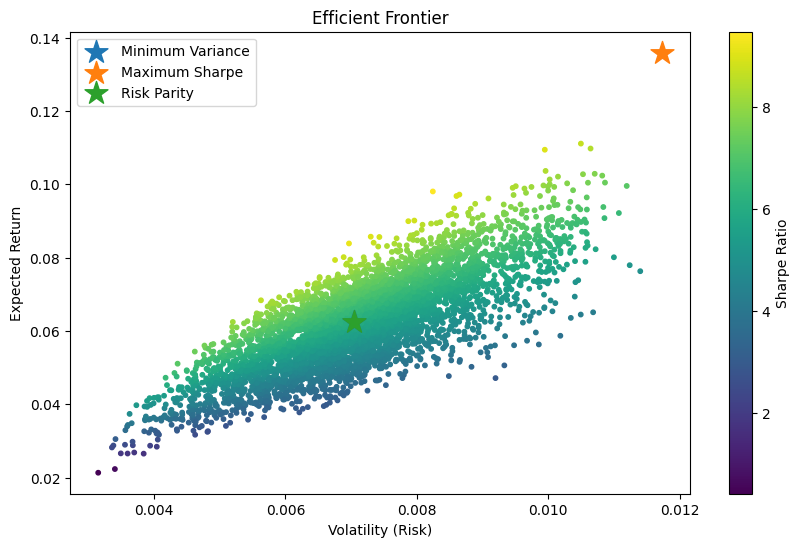

In [44]:
print("\nPortfolio Comparison")
print(results_df)

def plot_efficient_frontier(returns_df, num_portfolios=5000):
    np.random.seed(42)
    n_assets = len(returns_df.columns)
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        p_ret, p_vol, p_sharpe = calculate_portfolio_performance(weights, returns_df)
        results[0, i] = p_vol
        results[1, i] = p_ret
        results[2, i] = p_sharpe
    plt.figure(figsize=(10, 6))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', s=10)
    plt.colorbar(label='Sharpe Ratio')
    for res in [min_var_results, max_sharpe_results, risk_parity_results]:
        if res is not None:
            plt.scatter(res['volatility'], res['return'], marker='*', s=300, label=res['method'])
    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.show()
plot_efficient_frontier(log_returns)